# How to do the calibration

## Code setup

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import csv
import sys
import os

# The Algorithm

 - The first step is to let the IMU sit at rest for $T_{init}$ seconds. This interval is derived from the Allen Variance metnhod.
 - Also during this initial time interval, measure the average gyro readings in each axis: $\textbf{b}^g$
 - Let the IMU sit at some orientation for 4 seconds, then move it to some other orientation. Repeat this between 36 and 50 times.
 - Iterate over each gyroscope readings and subtract the bias $\text{b}^g$
 - Compute the magnitude of the variance $\varsigma_{init}$ for the accelerometer data over the $T_{init}$. To do this, you iterate over each accelerometer reading during $T_{init}$ and compute the sample variance. This is the average of the variance for each point: $var(a) = (a-\mathbb{E}[a])^2$. Do this for each axis.

#### A quick code example of this part:

In [2]:
x = [1.1, 1.2, 0.9, 0.9, 1.3, 0.8]
expected_value = np.mean(x)
print("expected_value: ", expected_value)
sample_variance = np.mean((x - expected_value)**2)
print("sample variance:", sample_variance)

expected_value:  1.03333333333
sample variance: 0.0322222222222


 - Iterate over a bunch of thresholds and compute how good each one is at calibrating the data. This is what the loop in Algorithm 1 refers to.
   - Set the threshold you're testing to $threshold = i * \varsigma_{init}$
   - Compute the regions of static/dynamic using that threshold
     - Iterate over each window of $t_{wait}$ size in the collected data and compute the sample variance (same as above) and compare to the threshold
     - If it's greater, the you classify as dynamics, otherwise as static
     - The output will be like the black line in Figure 3
   - Do the LM optimization (magic call the Eigen).
     - For this LM, we need to provide a functor that has `int operator()(const Eigen::VectorXf &x, Eigen::VectorXf &fvec) const` and `int df(const Eigen::VectorXf &x, Eigen::MatrixXf &fjac) const`. For `operator()` it should fill `fvec` with the values of the equation $e_k={\lVert g\rVert}^2 - {\lVert T^aK^a(a_k^S+b^a)\rVert}^2$, where ${\lVert g\rVert}^2 = 9.8$. For `df`, you fill `fjac` with each error term $\frac{\partial e_1}{\partial \theta^{acc}}, \dots, \frac{\partial e_k}{\partial \theta^{acc}}$.
      - Compute the residuals for the final optimized parameters
      - Save (residuals, params, threshold, intervals) if they're the best ones so far
 - Calibrate the accelerometer $a^o = T^aK^a(a^S+b^a)$
 - Calibrate the gyroscope using another LM. This time in `int operator()` you fill `fvec` with $\lVert(u_{a,k} - u_{g,k})\rVert$ and also the partials into `fjac`.

In [ ]:
## Setting up the Jacobians

Look in `docs/IMU_calibration.pdf`

## Evaluating the accuacy of numerical derivatives

In [3]:
def func(theta_acc):
    T = np.array([[1, -theta_acc[0], theta_acc[1]],[0, 1, -theta_acc[2]],[0,0,1]])
    K = np.array([[theta_acc[3],0,0],[0,theta_acc[4],0],[0,0,theta_acc[5]]])
    b = np.array([[theta_acc[6]],[theta_acc[7]],[theta_acc[8]]])
    return 1 - np.linalg.norm(T@K@(a_i + b))**2

def five_point_approximation(func, theta_acc, h):
    N = theta_acc.shape[1]
    partials = np.ndarray((N,1))
    for partial_idx in range(N):
        hs = np.array([-2*h, -h, h, 2*h])
        nodes = np.repeat(theta_acc, 4, axis=0)
        nodes[:,partial_idx] += hs
        five_point_approx = 1/(12*h)*(func(nodes[0]) - 8*func(nodes[1]) + 8*func(nodes[2]) - func(nodes[3]))
        partials[partial_idx] = five_point_approx
    return partials


# theta_acc = [a_yz, a_zy, a_zx, s_x_a, s_y_a, s_z_a, b_x_a, b_y_a, b_z_a]
theta_acc = np.array([[0.1, 0, 0.1, 1, 1, 1, 0, 0.1, 0]], dtype=np.float32)
a_i = np.array([[0.2], [0.7], [0.1]])
h = 0.1

print("five-point approximations")
print(five_point_approximation(func, theta_acc, h))

five-point approximations
[[ 0.192     ]
 [-0.024     ]
 [ 0.158     ]
 [-0.04800001]
 [-1.24480035]
 [-0.0042    ]
 [-0.24      ]
 [-1.556     ]
 [-0.042     ]]


In [4]:
data_filename = "recorded_sensor_data/imu_calibration_11_14_20-00-00/imu_calibration_data_11_14.csv"
reader = csv.reader(open(data_filename, 'r'))

next(reader) # skip header
data = []
for row in reader:
    data.append([float(x) for x in row])
data = np.array(data)

## iterate over the Tinit period to compute the gyro biases

In [5]:
Tinit = 4
samples_per_second = 100
Tinit_idx = int(Tinit * samples_per_second)
init_data = data[:Tinit_idx]
remaining_data = data[Tinit_idx:]
gyro_biases = np.mean(init_data, axis=0)[3:6]
data -= np.array([0, 0, 0, gyro_biases[0], gyro_biases[1], gyro_biases[2], 0])

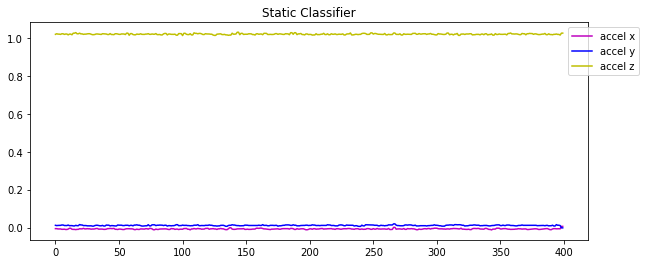

In [6]:
plt.figure(figsize=(10,4))
plt.title("Static Classifier")
plt.plot(init_data[:,0], label='accel x',c='m')
plt.plot(init_data[:,1], label='accel y', c='b')
plt.plot(init_data[:,2], label='accel z', c='y')
plt.legend(bbox_to_anchor=(1.1,1))
plt.show()

In [7]:
def get_static_intervals(threshold, data, t_wait, sample_per_second):
    window_size = int(sample_per_second * t_wait)
    if window_size % 2 == 0:
        window_size -= 1
    data_array_size = len(data)
    classifications = np.zeros(data_array_size)
    static_indicators = []
    temp_pair = [-1, -1]
    previously_static = False
    for i in range(data_array_size - window_size):
        window_data = data[i:i+window_size]
        center = i + window_size // 2
        variance = np.sum(np.var(window_data[:, :3], axis = 0)**2)
        
        #end of a static interval
        static = variance < threshold
        if not static and previously_static:
            temp_pair[1] = center
            static_indicators.append(temp_pair)
            temp_pair = [-1, -1]
        #start of a static intervals
        elif static and not previously_static:
            temp_pair[0] = center
        
        previously_static = static
        classifications[center] = 1 if static else 0
        
    if previously_static:
        print("static at the end")
        temp_pair[1] = data_array_size - window_size // 2 - 1
        static_indicators.append(temp_pair)
    
    return static_indicators, classifications    

In [34]:
def get_corrected_gyro_data(raw_data, theta_gyro):
    gamma_yz = theta_gyro[0]
    gamma_zy = theta_gyro[1]
    gamma_xz = theta_gyro[2]
    gamma_zx = theta_gyro[3]
    gamma_xy = theta_gyro[4]
    gamma_yx = theta_gyro[5]
    s_x = theta_gyro[6]
    s_y = theta_gyro[7]
    s_z = theta_gyro[8]
    T = np.array([[1, -gamma_yz, gamma_zy], [gamma_xz, 1, -gamma_zx], [-gamma_xy, gamma_yx, 1]])
    K = np.array([[s_x, 0, 0], [0, s_y, 0], [0, 0, s_z]])
    
    #corrected frame
    corretcted_data = [] 
    for w_s in raw_data:
        corretcted_data.append(T@K@w_s)
        
    return corretcted_data

def omega(gyro_frame):
    w_x = gyro_frame[0]
    w_y = gyro_frame[1]
    w_z = gyro_frame[2]
    return np.array([[0, -w_x, -w_y, -w_z], [w_x, 0, w_z, -w_y], [w_y, -w_z, 0, w_z], [w_z, w_y, -w_x, 0]])

def euler_to_quaternion(acc_frame):
    i = acc_frame[0]
    j = acc_frame[1]
    k = acc_frame[2]
    print("hi", acc_frame, "hi")
    return np.array([[1, i, j, k],[i, -1, k, -j],[j, -k, -1, i],[k, j, -i, -1]])
    
def thi(w_s_i, u_ak, theta_gyro, dt):
    # w_s is gyro scope data without bias
    # theta_gyro is [gamma_yz, gamma_zy, gamma_xz, gamma_zx, gamma_xy, gamma_yx, s_x, s_y, s_z]
    w_o = get_corrected_gyro_data(w_s_i, theta_gyro)
    
    u_gk = u_ak
    
    for corrected_gyro_frame in w_o:
        u_gk += 0.5 * (omega(corrected_gyro_frame) @ u_gk) * dt
    
    return u_gk
 
# print(get_corrected_gyro_data([np.array([[1],[1],[1]])], [1,1,1,1,1,1,2,3,2]))

wwww = np.array([[[3.14],[0],[0]], [[3.14],[0],[0]]])
uakk = np.array([9.8, 0, 0])
thet = [0,0,0,0,0,0,1,1,1]
dttt = .5




thi(wwww, euler_to_quaternion(uakk), thet, dttt)

hi [ 9.8  0.   0. ] hi


array([[-15.002225,   5.330995,   0.      ,   0.      ],
       [  5.330995,  15.002225,   0.      ,   0.      ],
       [  0.      ,   0.      ,  -1.      ,   9.8     ],
       [  0.      ,   0.      ,  -8.23    , -16.386   ]])

In [15]:
sigma_init = np.linalg.norm(np.var(init_data[:, :3], axis=0))
print("sigma_init:", sigma_init)

sigma_init: 1.0761588803e-05


In [ ]:
intervals, classifications = get_static_intervals(sigma_init, remaining_data, 2.5, samples_per_second)
plt.figure(figsize=(15,10))
plt.title("Static Classifier")
plt.plot(classifications, c='k', label="static")
plt.plot(remaining_data[:,0], label='accel x', alpha=0.4, c='m')
plt.plot(remaining_data[:,1], label='accel y', alpha=0.4, c='b')
plt.plot(remaining_data[:,2], label='accel z', alpha=0.4, c='y')
plt.legend(bbox_to_anchor=(1.1,1))
plt.show()
print(intervals)

In [ ]:
total_intervals = 20
s_intervals_opt = []
params_acc = []
threshold_opt = []
t_wait = 2
for i in range(1, total_intervals + 1):
    threshold = i * sigma_init**2
    intervals, classifications = get_static_intervals(threshold, remaining_data, t_wait, samples_per_second)

### References

- https://www.math.uwaterloo.ca/~hwolkowi/matrixcookbook.pdf
 - http://eigen.tuxfamily.org/bz_attachmentbase/attachment.cgi?id=395
 - https://medium.com/@sarvagya.vaish/levenberg-marquardt-optimization-part-1-981f5777b1d7
 - https://medium.com/@sarvagya.vaish/levenberg-marquardt-optimization-part-2-5a71f7db27a0
 - https://github.com/SarvagyaVaish/Eigen-Levenberg-Marquardt-Optimization/blob/master/main.cpp